In [55]:
#import libraries

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import os
import pandas as pd

raw_data = pd.read_csv('d2l-en/Local/kaggleSpaceship/resources/train.csv')
raw_test_data = pd.read_csv('d2l-en/Local/kaggleSpaceship/resources/test.csv')


In [99]:
raw_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [122]:
# raw_data['HomePlanet'].unique(), raw_data['CryoSleep'].unique()
# nan_count = raw_data['Cabin'].isna().sum()
# nan_count

# raw_data['PassengerId'].count()

columns_list = raw_data.columns
columns_list

# Check for nan values in each column
for column in columns_list:
    nan_count = raw_data[column].isna().sum()
    print(f'{column} has {nan_count} nan values')

# Check for unique values in each column
for column in columns_list:
    unique_values = raw_data[column].unique()
    print(f'{column} has {len(unique_values)} unique values {unique_values}')

def cleanData(raw_data):

    # data['Age'].fillna(data['Age'].mean(), inplace=True)
    # data['Fare'].fillna(data['Fare'].mean(), inplace=True)
    # data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

    raw_data['HomePlanet'].fillna('Earth', inplace=True)
    raw_data['CryoSleep'].fillna(False, inplace=True)
    raw_data['VIP'].fillna(False, inplace=True)
    raw_data['Destination'].fillna("Unknown", inplace=True)
    raw_data['Age'].fillna(raw_data['Age'].mean(), inplace=True)
    raw_data['RoomService'].fillna(raw_data['RoomService'].mean(), inplace=True)
    raw_data['FoodCourt'].fillna(raw_data['FoodCourt'].mean(), inplace=True)
    raw_data['ShoppingMall'].fillna(raw_data['ShoppingMall'].mean(), inplace=True)
    raw_data['Spa'].fillna(raw_data['Spa'].mean(), inplace=True)
    raw_data['VRDeck'].fillna(raw_data['VRDeck'].mean(), inplace=True)

    cleaned_data = raw_data.drop(columns=['PassengerId', 'Name', 'Cabin'])
    homePlanet_mapping = {'Europa': 0, 'Earth': 1, 'Mars': 2}
    cryoSleep_mapping = {False: 0, True: 1}
    destination_mapping = {'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2, 'Unknown': 3}
    vip_mapping = {False: 0, True: 1}
    transported_mapping = {False: 0, True: 1}

    cleaned_data['HomePlanet'] = raw_data['HomePlanet'].map(homePlanet_mapping)
    cleaned_data['CryoSleep'] = raw_data['CryoSleep'].map(cryoSleep_mapping)
    cleaned_data['Destination'] = raw_data['Destination'].map(destination_mapping)
    cleaned_data['VIP'] = raw_data['VIP'].map(vip_mapping)
    cleaned_data['Transported'] = raw_data['Transported'].map(transported_mapping)

    return cleaned_data

clean_data = cleanData(raw_data)
clean_data.head()

labels = torch.tensor(clean_data[clean_data.columns[10]].values, dtype=torch.long)
data = torch.tensor(clean_data[clean_data.columns[0:10]].values, dtype=torch.float32)

clean_data.head()

# Comments:
# 1. 8693 passengers after dropna -> after clean nan 6606 passengers dropped
# 2. HomePlanet has 5 unique values ['Europa', 'Earth', 'Mars', nan] -> 201 nan values
# 3. CryoSleep has 2 unique values [0, 1] -> 0 nan values
# 4. For training data we can drop PassengerId, Name, Cabin columns


PassengerId has 0 nan values
HomePlanet has 0 nan values
CryoSleep has 217 nan values
Cabin has 199 nan values
Destination has 182 nan values
Age has 0 nan values
VIP has 203 nan values
RoomService has 0 nan values
FoodCourt has 0 nan values
ShoppingMall has 0 nan values
Spa has 0 nan values
VRDeck has 0 nan values
Name has 200 nan values
Transported has 0 nan values
PassengerId has 8693 unique values ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
HomePlanet has 3 unique values ['Europa' 'Earth' 'Mars']
CryoSleep has 3 unique values [False True nan]
Cabin has 6561 unique values ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination has 4 unique values ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Age has 81 unique values [39.         24.         58.         33.         16.         44.
 26.         28.         35.         14.         34.         45.
 32.         48.         31.         27.          0.          1.
 49.         29.         10.    

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1
2,0,0,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0
3,0,0,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0
4,1,0,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1


In [123]:
clean_columns_list = clean_data.columns
for column in clean_columns_list:
    nan_count = clean_data[column].isna().sum()
    print(f'{column} has {nan_count} nan values')

HomePlanet has 0 nan values
CryoSleep has 0 nan values
Destination has 0 nan values
Age has 0 nan values
VIP has 0 nan values
RoomService has 0 nan values
FoodCourt has 0 nan values
ShoppingMall has 0 nan values
Spa has 0 nan values
VRDeck has 0 nan values
Transported has 0 nan values


In [124]:
def buildModel(lr):
    model = nn.Sequential(
        nn.Linear(10, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
        # nie dodajemy softmaxa, bo jest juz w CrossEntropyLoss()
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, loss_fn, optimizer


def trainMode(epochs, data, labels, model, loss_fn, optimizer):

    losses = torch.zeros(epochs)
    ongoingAcc = []

    for epoch in range(epochs):

        #forward pass
        y_pred = model(data)

        #compute loss
        loss = loss_fn(y_pred, labels)
        losses[epoch] = loss

        #back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #compute accuracy
        matches = torch.argmax(y_pred, axis=1) == labels #check if y_pred is equal to labels
        matchesNumeric = matches.float() #convert to float
        accuracyPct = 100 * torch.mean(matchesNumeric) #calculate accuracy
        ongoingAcc.append(accuracyPct) #append accuracy to list

    return losses, loss, accuracyPct, ongoingAcc


def createAccuracyLossesPlot(losses, ongoingAcc):
    
    fix, ax = plt.subplots(1, 2, figsize=(13, 4))

    ax[0].plot(losses.detach())
    ax[0].set_title('Losses')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(ongoingAcc)
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy (%)')

    plt.show()

def roundValues(model, data):
    preditcions = model(data)
    sm = nn.Softmax(dim=1)
    preditcions = sm(preditcions)
    preditcions = torch.argmax(preditcions, axis=1)
    return preditcions

In [125]:
lr = 0.01
epochs = 1000

model, loss_fn, optimizer = buildModel(lr)
losses, loss, accuracyPct, ongoingAcc = trainMode(epochs, data, labels, model, loss_fn, optimizer)

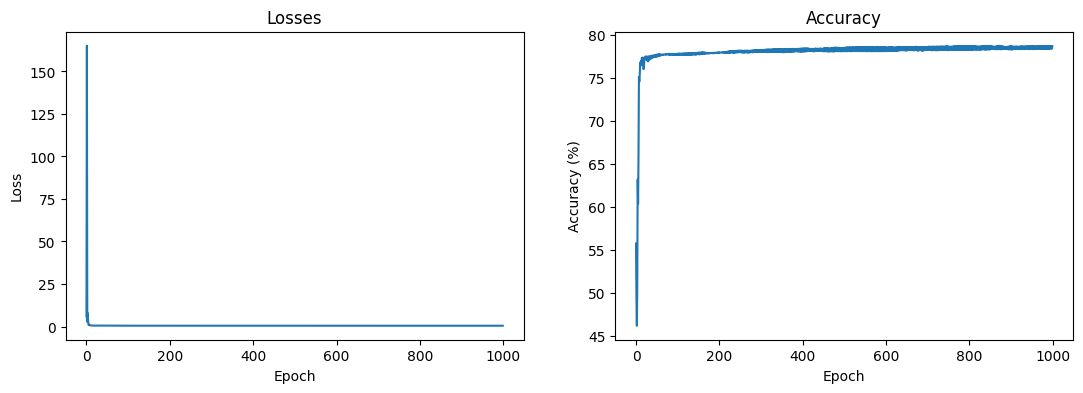

In [126]:
createAccuracyLossesPlot(losses, ongoingAcc)
raw_test_data['Transported'] = False

In [136]:
clean_test_data = cleanData(raw_test_data)
clean_test_data_for_prediction = torch.tensor(clean_test_data[clean_test_data.columns[0:10]].values, dtype=torch.float32)
clean_test_data_for_prediction

model(clean_test_data_for_prediction)

def roundValues(model, data):
    preditcions = model(data)
    sm = nn.Softmax(dim=1)
    preditcions = sm(preditcions)
    preditcions = torch.argmax(preditcions, axis=1)
    return preditcions

preditcions = roundValues(model, clean_test_data_for_prediction)
preditcions

predictions_df = pd.DataFrame(preditcions.numpy(), columns=['Transported'])
predictions_df

result_df = pd.concat([raw_test_data['PassengerId'].reset_index(drop=True), predictions_df], axis=1)

result_df['Transported'] = result_df['Transported'].map({0: False, 1: True})
result_df

result_df.to_csv('d2l-en/Local/kaggleSpaceship/resources/submission.csv', index=False)